In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt




In [5]:
name = 'house'
data_dir = 'data'

# images
I1 = plt.imread(data_dir + '/' + name + '/' + name + '1.jpg')
I2 = plt.imread(data_dir + '/' + name + '/' + name + '2.jpg')

# K matrices
qq = loadmat(data_dir + '/' + name + '/' + name + '1_K.mat')
K1 = qq['K']
qq = loadmat(data_dir + '/' + name + '/' + name + '2_K.mat')
K2 = qq['K']

# corresponding points
matches = [x.split('  ')[1:] for x in open(data_dir + '/' + name + '/house_matches.txt').readlines()] 
matches = [[float(y) for y in x] for x in matches]
matches = np.array(matches)

# this is a N x 4 where:
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is the corresponding point in the second image

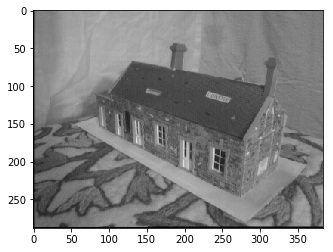

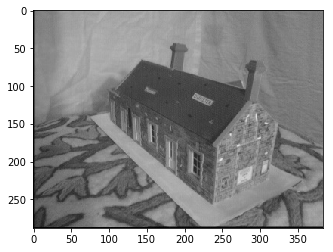

matches shape: (168, 4)


In [6]:
plt.imshow(I1)
plt.show()
plt.imshow(I2)
plt.show()
print("matches shape:", matches.shape)

In [57]:
'''The function that returns the fundamental matrix described in 1.4.1 (Eight Point Algorithm).
This function takes in atleast 8 corresponding points and returns the matrix F and the residual.
'''
def fundamental_matrix(matches):
    #TODO (do this with normalization)
    pass

'''Given E, calculates and returns both the rotation and translation between the two cameras.
Described in part 1.4.2. Returning the magnitude of t is impossible, so we return
an array of possible t's and an array of possible R's.
'''
def find_rotation_translation(E):
    #TODO
    pass

'''Triangulation function. This takes in the matches, P1, P2, and
finds the best 3D points that reproject to the images in the
two cameras.

This returns a Nx3 matrix of points in 3D space and the 
reconstruction scene. N depends on the number of points
that end up in front of the images planes.'''
def find_3d_points(matches, P1, P2):
    #TODO
    pass

In [58]:
#TODO: visualize matches (maybe)
F, res_err = fundamental_matrix(matches)
print('Residual in f = ', res_err)

#calculate the ESSENTIAL matrix from the FUNDAMENTAL matrix
E = K2 @ F @ K1

# R : cell array with the possible rotation matrices of second camera
# t : cell array of the possible translation vectors of second camera
R, t = find_rotation_translation(E) 


#P1: P matrix for camera 1
#P2 is calculated on the fly since there are multiple possibilities
P1 = K1 @ np.concatenate(np.identity(3), np.zeros(3), axis=1)

# % the number of points in front of the image planes for all combinations
num_points = np.zeros((len(t), len(R)))
# % the reconstruction error for all combinations
errs = np.full((len(t), len(R)), np.inf)


for ti in range(len(t)):
    t2 = t[ti]
    for ri in range(len(R)):
        R2 = R[ri]
        P2 = K2 @ np.concatenate(R2, t2, axis=1)
        points_3d,  errs[ti, ri] = find_3d_points(matches) #TODO might need more params
        Z1 = points_3d[:, 3] #not sure if this should be 2 -sherman
        Z2 = R2[3, :]@points_3d.T + t2[3]
        Z2 = Z2.T
        num_points[ti, ri] = points_3d.shape[0]

TypeError: cannot unpack non-iterable NoneType object